# Project Setup

## Installing Required Libraries

Installing the libraries required by this project

In [1]:
!pip install tensorflow
!pip install tensorflow-hub
!pip install scikit-learn
!pip install keras-tuner
!pip install seaborn 
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Data Preprocessing

It was noted that some of the folders, in particular the art style ukiyo e had different names for the folders across the Latend Diffusion, Stable DIffusion and Human Samples. Considerations we made and the folders were renamed "ukiyo-e" across the test and train samples to help with the functions created to auto train and test

## Dataset Preparation

Creating a reference to the base location of all the files

In [4]:
import os #used in this instance to get the relative location of the notebook

#set the base directory NB windows using relative paths causes errors
BASE_LOC = os.getcwd();
print(BASE_LOC)#ensure current directory is not relative

/home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset


Creating a function to return a file list from a particular directory

In [5]:
import os
import random
import pandas as pd

def generate_image_df(directory, label, sample_size=None):
    data = {'filepath': [], 'label': []}

    #collect file paths and labels
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        data['filepath'].append(filepath)
        data['label'].append(label)

    #if we give a specified # of samples to use
    if sample_size is not None:
        if sample_size >= len(data['filepath']):
            return pd.DataFrame(data)  #return all if sample_size is greater or equal to the number of files
        else:
            indices = random.sample(range(len(data['filepath'])), sample_size)
            sampled_data = {key: [data[key][i] for i in indices] for key in data}
            return pd.DataFrame(sampled_data)

    return pd.DataFrame(data)

Creating a function to prepare a dataset based on the above function returning a list for each of the particular generation styles of a singe art style

In [6]:
def artstyle_dataset(train_or_test, art_style, sample_size):
    file_location = os.path.join(BASE_LOC, 'train')

    if train_or_test == 'test':
        file_location = os.path.join(BASE_LOC, 'test')

    # half the sample size for each AI style
    ai_hum_samp = sample_size // 2

    # get human samples
    human_location = os.path.join(file_location, art_style)
    print("Location of human samples:", human_location)
    human_data = generate_image_df(human_location, "HU", sample_size)

    ai_sd_location = os.path.join(file_location, 'AI_SD_' + art_style)
    print("Location of ai_sd samples:", ai_sd_location)
    ai_sd_data = generate_image_df(ai_sd_location, 'AI', ai_hum_samp)

    ai_ld_location = os.path.join(file_location, 'AI_LD_' + art_style)
    print("Location of ai_ld samples:", ai_ld_location)
    ai_ld_data = generate_image_df(ai_ld_location, 'AI', ai_hum_samp)

    # Combine human and AI data
    dataset = pd.concat([human_data, ai_sd_data, ai_ld_data], ignore_index=True)
    
    return dataset

Testing the genertae_image_df function

In [5]:
ukiyoe_tr_1_10 = artstyle_dataset('train', 'ukiyo-e', 500)
ukiyoe_1_10_file_counts = ukiyoe_tr_1_10['label'].value_counts()
#print value count
print(f"\nLABEL COUNTS ON ukiyoe_tr_1_10 TRAINING SET")
print(ukiyoe_1_10_file_counts)
print('\n')

Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/train/ukiyo-e
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/train/AI_SD_ukiyo-e
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/train/AI_LD_ukiyo-e

LABEL COUNTS ON ukiyoe_tr_1_10 TRAINING SET
label
HU    500
AI    500
Name: count, dtype: int64




Clearing the variables to clear memeory

In [6]:
del ukiyoe_tr_1_10
del ukiyoe_1_10_file_counts

## CNN Setup

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

def CNN_artystyle(filters=64, kernel_size=3, input_shape=(240, 240, 3), dense_units=64, output_units=2, activation='relu'):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(0.5))  # Add dropout layer to reduce overfitting
    model.add(Dense(units=output_units, activation='sigmoid'))
    
    # Configure early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    return model, early_stopping

2024-04-19 13:26:55.561358: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 13:26:57.247630: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 13:27:00.887887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 13:27:09.554273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Creating the training function

In [8]:
import time

def CNN_img_TRAIN_MODEL(model, training_dataset, validation_dataset, model_checkpoint, early_stopping, epochs=13):
    #init training time
    total_training_time = 0

    start_time = time.time()

    #fit the model for the specified number of epochs
    history = model.fit(training_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[model_checkpoint, early_stopping])

    #calculate training time for the current batch of epochs
    training_time = time.time() - start_time
    total_training_time += training_time

    #print total training time
    print("Total training time so far: {:.2f} seconds".format(total_training_time))

    return history

# Auto Train Function

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

def CNN_train_artstyle(artstyle, sample_size=None, validation_split=0.2):
    #creating the training set
    init_dataset = artstyle_dataset('train', artstyle, sample_size)
    init_dataset_counts = init_dataset['label'].value_counts()
    #print value count
    print(f"\nLABEL COUNTS ON {artstyle} TRAINING SET")
    print(init_dataset_counts)
    print('\n')

    #splitting the init dataset into train and validation
    from sklearn.model_selection import train_test_split

    train, vali = train_test_split(init_dataset, test_size=validation_split, random_state=42)

    #preprocess training set
    train_dataset_gen = ImageDataGenerator(
        rescale=1./255,   # to normalize pixel value
        #rotation_range=7, # it will apply rotations to the image
        #horizontal_flip=True, # it will flip image horizontally
        #zoom_range=0.2  # it will increase and decrease zoom by 0.2x
    )

    train_dataset = train_dataset_gen.flow_from_dataframe(
        dataframe=train,
        x_col='filepath',  # Column containing file paths
        y_col='label',     # Column containing labels
        target_size=(240, 240),
        batch_size=64,
        class_mode='categorical',  
        shuffle=True
    )

    print (train_dataset.class_indices)

    #preprocess training set
    vali_dataset_gen = ImageDataGenerator(
        rescale=1./255,   # to normalize pixel value
        rotation_range=7, # it will apply rotations to the image
        horizontal_flip=True, # it will flip image horizontally
        zoom_range=0.2  # it will increase and decrease zoom by 0.2x
    )

    vali_dataset = vali_dataset_gen.flow_from_dataframe(
        dataframe=vali,
        x_col='filepath',  # Column containing file paths
        y_col='label',     # Column containing labels
        target_size=(240, 240),
        batch_size=64,
        class_mode='categorical',  
        shuffle=True
    )

    print (vali_dataset.class_indices)

    #create the model
    CNN_model, CNN_model_ES = CNN_artystyle()

    #create checkpoint
    os.makedirs('models_checkpoints', exist_ok=True)
    model_file_name = f'CNN_{artstyle}'
    
    #create location for check point
    current_dir = os.getcwd()
    filename = (f'models_checkpoints/{model_file_name}.keras')
    checkpoint_filepath = os.path.join(current_dir, filename)

    #create a checkpoint
    CNN_model_CheckPoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    #compile the model
    # Compile the model
    learning_rate = 1e-4
    optimizer = Adam()
    CNN_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    #train the model
    model_history = CNN_img_TRAIN_MODEL(CNN_model, train_dataset, vali_dataset, CNN_model_CheckPoint, CNN_model_ES)

    #save model after training
    os.makedirs('models_trained', exist_ok=True)
    CNN_model.save(f'models_trained/{model_file_name}.keras')

    return model_history


Testing model after training

In [10]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import os
import numpy as np

def CNN_eval_model(artstyle, sample_size=None, validation_split=0.2):
    # creating the testing set
    init_dataset = artstyle_dataset('test', artstyle, sample_size)
    init_dataset_counts = init_dataset['label'].value_counts()

    # print value count
    print(f"\nLABEL COUNTS ON {artstyle} TESTING SET")
    print(init_dataset_counts)
    print('\n')

    # preprocess testing set
    test_dataset_gen = ImageDataGenerator(
        rescale=1./255,   # to normalize pixel value
        # rotation_range=7, # it will apply rotations to the image
        # horizontal_flip=True, # it will flip image horizontally
        # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
    )

    test_dataset = test_dataset_gen.flow_from_dataframe(
        dataframe=init_dataset,
        x_col='filepath',  # Column containing file paths
        y_col='label',     # Column containing labels
        target_size=(240, 240),
        batch_size=64,
        class_mode='categorical',  
        shuffle=True
    )

    print(test_dataset.class_indices)

    # Convert test_dataset to arrays
    test_data, test_labels = [], []
    for batch_data, batch_labels in test_dataset:
        test_data.append(batch_data)
        test_labels.append(batch_labels)
        if len(test_data) * 64 >= len(init_dataset):
            break
    test_data = np.vstack(test_data)
    test_labels = np.vstack(test_labels)

    # Load the model
    model_folder = "models_trained"
    model_filename = f"CNN_{artstyle}.keras"
    model_path = os.path.join(model_folder, model_filename)

    # Evaluate the model on the entire test dataset (regular evaluation)
    model = load_model(model_path)
    regular_evaluation_results = model.evaluate(test_dataset)

    regular_evaluation_dict = {model.metrics_names[i]: value for i, value in enumerate(regular_evaluation_results)}

    return regular_evaluation_dict


In [11]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import os
import numpy as np

def CNN_eval_model_kfolds(artstyle, k_folds=5, sample_size=None, validation_split=0.2):
    # creating the testing set
    init_dataset = artstyle_dataset('test', artstyle, sample_size)
    init_dataset_counts = init_dataset['label'].value_counts()

    # print value count
    print(f"\nLABEL COUNTS ON {artstyle} TESTING SET")
    print(init_dataset_counts)
    print('\n')

    # preprocess testing set
    test_dataset_gen = ImageDataGenerator(
        rescale=1./255,   # to normalize pixel value
        # rotation_range=7, # it will apply rotations to the image
        # horizontal_flip=True, # it will flip image horizontally
        # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
    )

    test_dataset = test_dataset_gen.flow_from_dataframe(
        dataframe=init_dataset,
        x_col='filepath',  # Column containing file paths
        y_col='label',     # Column containing labels
        target_size=(240, 240),
        batch_size=64,
        class_mode='categorical',  
        shuffle=False
    )

    print(test_dataset.class_indices)

    # Load the model
    model_folder = "models_trained"
    model_filename = f"CNN_{artstyle}.keras"
    model_path = os.path.join(model_folder, model_filename)

    # Evaluate the model on the entire test dataset (regular evaluation)
    model = load_model(model_path)
    test_data, test_labels = [], []
    for batch_data, batch_labels in test_dataset:
        test_data.append(batch_data)
        test_labels.append(batch_labels)
    test_data = np.vstack(test_data)
    test_labels = np.vstack(test_labels)

    # Perform k-fold cross-validation
    kf = KFold(n_splits=k_folds)
    evaluation_results = []
    for train_index, val_index in kf.split(test_data):
        X_train, X_val = test_data[train_index], test_data[val_index]
        y_train, y_val = test_labels[train_index], test_labels[val_index]
        
        # Train the model on training data
        model.fit(X_train, y_train)
        
        # Evaluate the model on validation data
        evaluation_result = model.evaluate(X_val, y_val)
        evaluation_results.append(evaluation_result)

    # Calculate mean of evaluation results for each metric
    mean_evaluation_results = np.mean(evaluation_results, axis=0)

    # Create dictionary to store the evaluation results
    evaluation_dict = {metric_name: value for metric_name, value in zip(model.metrics_names, mean_evaluation_results)}
    
    return evaluation_dict

Save history as a json file

In [12]:
import json
import os
import numpy as np

def save_training_history(history, filename):
    # Convert non-serializable parts to serializable format
    serializable_history = {}
    for key, value in history.items():
        if isinstance(value, np.ndarray):
            serializable_history[key] = value.tolist()
        else:
            serializable_history[key] = value

    directory_path = 'models_history'
    curr_dir = os.getcwd()
    full_dir_path = os.path.join(curr_dir, directory_path)

    if not os.path.exists(full_dir_path):
        os.makedirs(full_dir_path)

    file_path = os.path.join(full_dir_path, filename)

    with open(file_path, 'w') as file:
        json.dump(serializable_history, file)
    
    print('Training history saved to', file_path)

Function to plot metrics from training

In [13]:
import os
import json
import matplotlib.pyplot as plt

def plot_training_metrics(file_name):
    current_path = os.getcwd()
    metrics_path = os.path.join(current_path, "models_history", file_name)

    with open(metrics_path, 'r') as file:
        metrics_data = json.load(file)

    epochs = range(1, len(metrics_data['accuracy']) + 1)

    # Plotting accuracy
    plt.plot(epochs, metrics_data['accuracy'], 'bo', label='Training accuracy')
    plt.plot(epochs, metrics_data['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure()

    # Plotting loss
    plt.plot(epochs, metrics_data['loss'], 'bo', label='Training loss')
    plt.plot(epochs, metrics_data['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [14]:
#ukiyo_history = CNN_train_artstyle('ukiyo-e', sample_size=4500)

In [15]:
#save_training_history(ukiyo_history.history, 'ukiyoe_history.json')

In [16]:
#realism_history = CNN_train_artstyle('realism', sample_size=4500)

In [17]:
#save_training_history(realism_history.history, 'realism_history.json')

### Baroque

In [18]:
#baroque_history = CNN_train_artstyle('baroque', sample_size=4500)
#save_training_history(baroque_history.history, 'baroque_history.json')

### Expressionism

In [19]:
#expressionism_history = CNN_train_artstyle('expressionism', sample_size=4500)
#save_training_history(expressionism_history.history, 'expressionism_history.json')

### Impressionism

In [20]:
#impressionism_history = CNN_train_artstyle('impressionism', sample_size=4500)
#save_training_history(impressionism_history.history, 'impressionism_history.json')

### Post Impressionism

In [21]:
#post_impressionism_history = CNN_train_artstyle('post_impressionism', sample_size=4500)
#save_training_history(post_impressionism_history.history, 'post_impressionism_history.json')

### Renaissance

In [22]:
#renaissance_history = CNN_train_artstyle('renaissance', sample_size=4500)
#save_training_history(renaissance_history.history, 'renaissance_history.json')

### Romanticism

In [23]:
#romanticism_history = CNN_train_artstyle('romanticism', sample_size=4500)
#save_training_history(romanticism_history.history, 'romanticism_history.json')

### Surrealism

In [24]:
#surrealism_history = CNN_train_artstyle('surrealism', sample_size=4500)
#save_training_history(surrealism_history.history, 'surrealism_history.json')

### Art Nouveau

In [25]:
#art_nouveau_history = CNN_train_artstyle('art_nouveau', sample_size=4500)
#save_training_history(art_nouveau_history.history, 'art_nouveau_history.json')

## Plotting Training Metrics

### Baroque

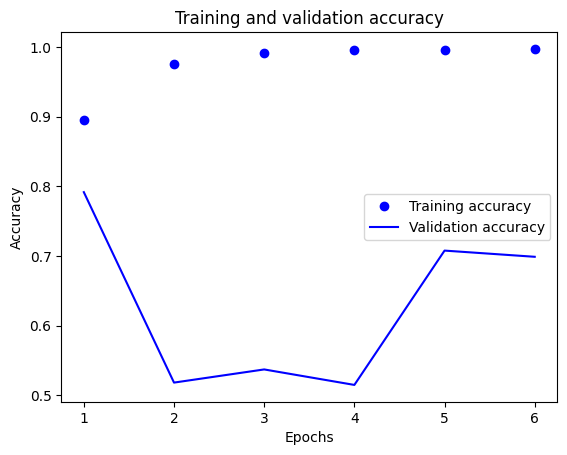

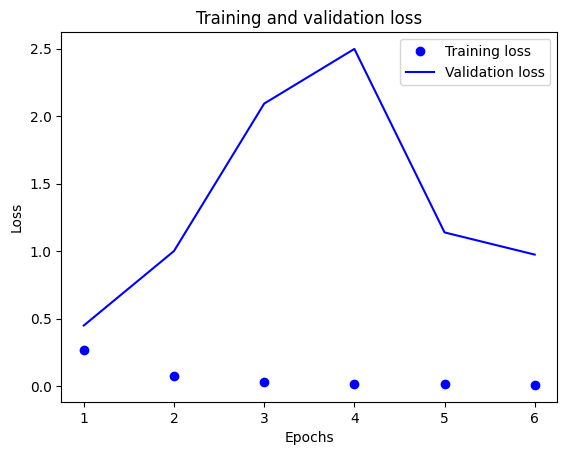

In [26]:
plot_training_metrics('baroque_history.json')

### Expressionism

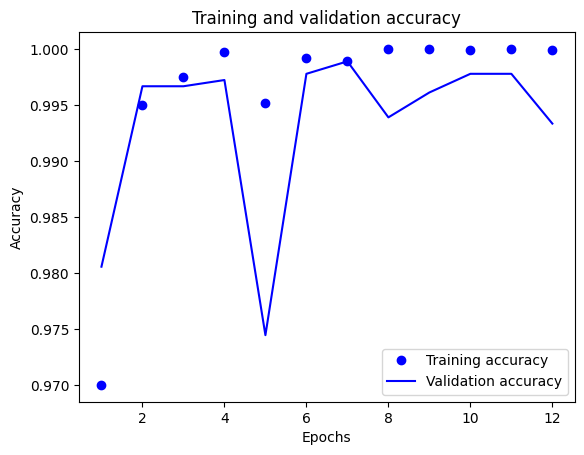

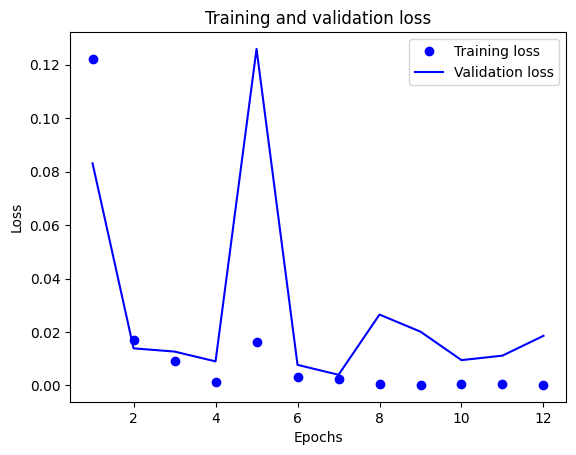

In [27]:
plot_training_metrics('expressionism_history.json')

### Impressionism

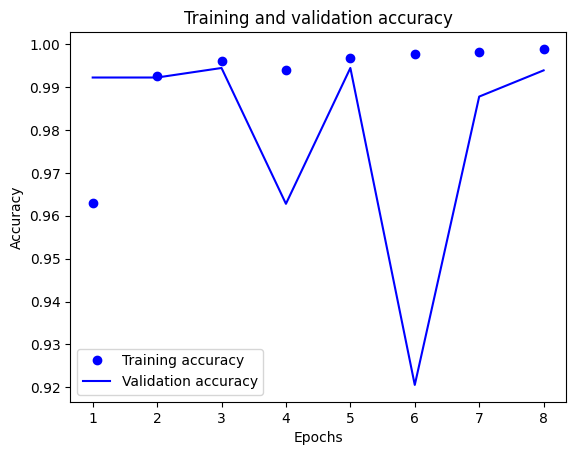

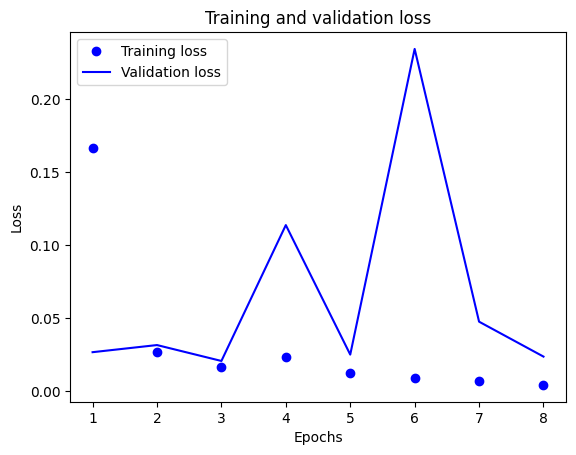

In [28]:
plot_training_metrics('impressionism_history.json')

### Post Impressionism

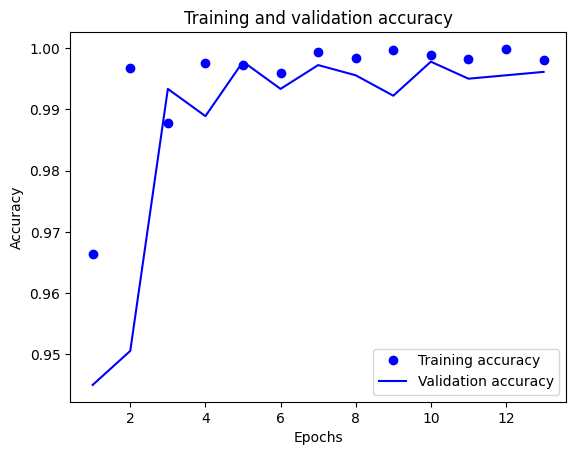

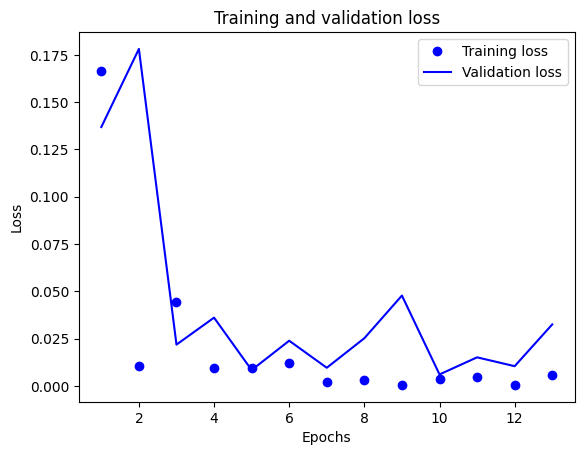

In [29]:
plot_training_metrics('post_impressionism_history.json')

### Realism

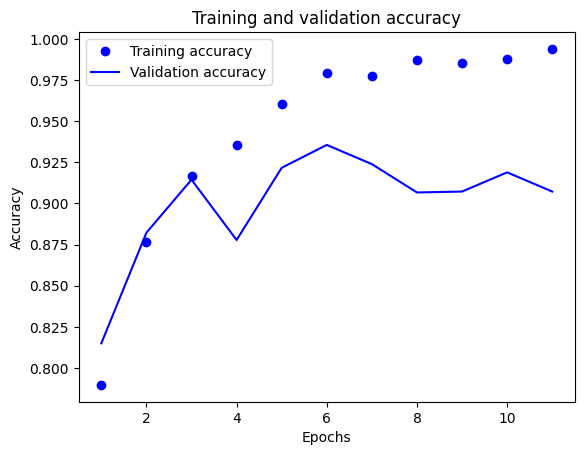

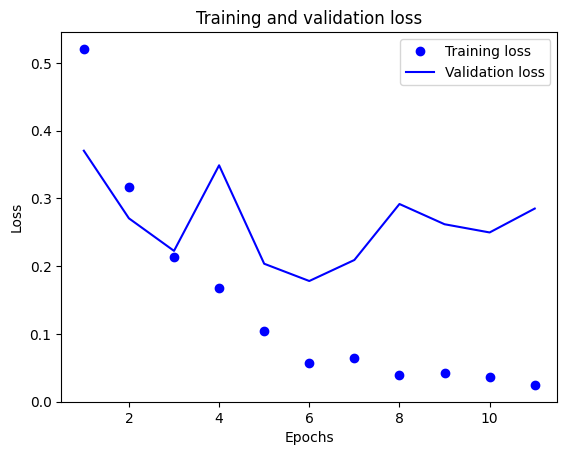

In [30]:
plot_training_metrics('realism_history.json')

### Ukiyo-e

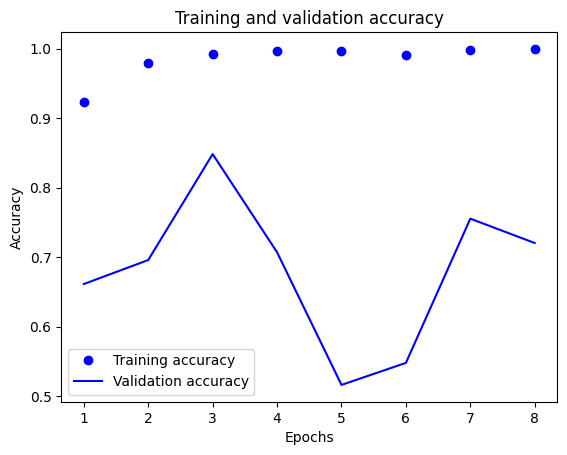

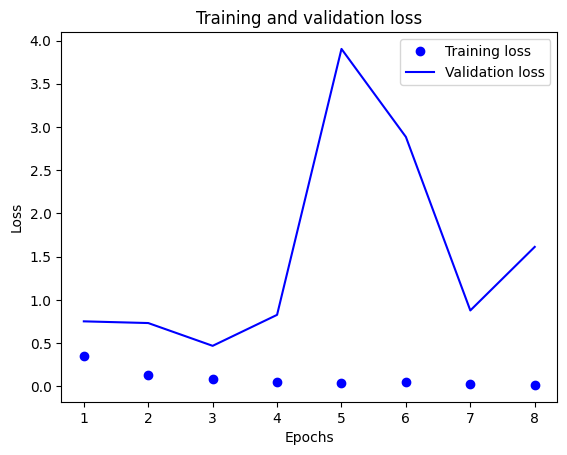

In [31]:
plot_training_metrics('ukiyoe_history.json')

### Testing Models Using KFolds

In [32]:
baroque_eval = CNN_eval_model('baroque', 450)
print(baroque_eval)

Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/baroque
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_SD_baroque
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_LD_baroque

LABEL COUNTS ON baroque TESTING SET
label
HU    450
AI    450
Name: count, dtype: int64


Found 900 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


/home/g0dbot/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-19 13:27:52.539166: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 928055296 exceeds 10% of free system memory.
2024-04-19 13:27:53.582464: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 232013824 exceeds 10% of free system memory.
2024-04-19 13:27:53.909607: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224280576 exceeds 10% of free system memory.


 1/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7500 - loss: 1.3308

2024-04-19 13:27:54.602272: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 928055296 exceeds 10% of free system memory.
2024-04-19 13:27:55.285536: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 232013824 exceeds 10% of free system memory.


15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8075 - loss: 0.8523
{'loss': 0.6857958436012268, 'compile_metrics': 0.8233333230018616}


In [33]:
baroque_eval_kfold = CNN_eval_model_kfolds('baroque', 5, 450)
for metric_name, metric_value in baroque_eval_kfold.items():
    print(f"{metric_name}: {metric_value}")

Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/baroque
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_SD_baroque
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_LD_baroque

LABEL COUNTS ON baroque TESTING SET
label
HU    450
AI    450
Name: count, dtype: int64


Found 900 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}


In [27]:
import os
import random
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score

# Directory containing the subfolders with model files
base_directory = "test"

# List all subfolders in the base directory
subfolders = [os.path.join(base_directory, subfolder) for subfolder in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, subfolder))]

# List all model files from all subfolders
model_files = []
for subfolder in subfolders:
    model_files.extend([os.path.join(subfolder, file) for file in os.listdir(subfolder) if file.endswith(".keras")])

# Load pre-trained Keras models
models = [load_model(file) for file in model_files]

test_data = artstyle_dataset('train', 'baroque', 200)

# preprocess testing set
test_dataset_gen = ImageDataGenerator(
    rescale=1./255,   # to normalize pixel value
    # rotation_range=7, # it will apply rotations to the image
    # horizontal_flip=True, # it will flip image horizontally
    # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)

test_dataset = test_dataset_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',  
    shuffle=False
)

print(test_dataset.class_indices)

features, labels = next(test_dataset)

# Check the shape of features and labels
print("Shape of features:", features.shape)
print("Shape of labels:", labels.shape)

Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/train/baroque
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/train/AI_SD_baroque
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/train/AI_LD_baroque
Found 400 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Shape of features: (1, 240, 240, 3)
Shape of labels: (1, 2)


/home/g0dbot/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/g0dbot/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [49]:
import os
import random
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score

# Directory containing the subfolders with model files
models_dir = "models_trained"

# List all model files from the subfolder
model_files = [os.path.join(models_dir, file) for file in os.listdir(models_dir) if file.endswith(".keras")]

print(model_files)

# Load pre-trained Keras models
models = [load_model(file) for file in model_files]

test_data = artstyle_dataset('test', 'baroque', 100)

# Preprocess testing set
test_dataset_gen = ImageDataGenerator(
    rescale=1./255,  # to normalize pixel value
    # rotation_range=7,  # it will apply rotations to the image
    # horizontal_flip=True,  # it will flip image horizontally
    # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)
test_dataset = test_dataset_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',  # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print(test_dataset.class_indices)

# Define empty lists to store features and labels
features = []
labels = []

# Iterate over all batches in the test dataset
for i in range(len(test_dataset)):
    batch_features, batch_labels = test_dataset[i]
    if np.isnan(batch_features).any() or np.isnan(batch_labels).any():
        print(f"Found nan values in batch {i}")
    else:
        features.append(batch_features)
        labels.append(batch_labels)

# Concatenate the features and labels into numpy arrays
features = np.concatenate(features)
labels = np.concatenate(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
#print(labels)

# Define a list to store predictions from each model
all_predictions = []

# Iterate over each model
for model in models:
    # Make predictions using the current model
    predictions = model.predict(features)
    # Append the predictions to the list
    all_predictions.append(predictions)

ensemble_predictions = np.mean(all_predictions, axis=0)

# Evaluate the correctness of the predictions
correct_predictions = np.argmax(ensemble_predictions, axis=1) == np.argmax(labels, axis=1)
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

['models_trained/CNN_realism.keras', 'models_trained/CNN_impressionism.keras', 'models_trained/CNN_baroque.keras', 'models_trained/CNN_post_impressionism.keras', 'models_trained/CNN_ukiyo-e.keras', 'models_trained/CNN_expressionism.keras']
Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/baroque
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_SD_baroque
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_LD_baroque
Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Features shape: (200, 240, 240, 3)
Labels shape: (200, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 669ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 660ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 644ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 642ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 645ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 661ms/step
Accuracy: 0.585


In [50]:
test_data = artstyle_dataset('test', 'expressionism', 100)

# Preprocess testing set
test_dataset_gen = ImageDataGenerator(
    rescale=1./255,  # to normalize pixel value
    # rotation_range=7,  # it will apply rotations to the image
    # horizontal_flip=True,  # it will flip image horizontally
    # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)
test_dataset = test_dataset_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',  # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print(test_dataset.class_indices)

# Define empty lists to store features and labels
features = []
labels = []

# Iterate over all batches in the test dataset
for i in range(len(test_dataset)):
    batch_features, batch_labels = test_dataset[i]
    if np.isnan(batch_features).any() or np.isnan(batch_labels).any():
        print(f"Found nan values in batch {i}")
    else:
        features.append(batch_features)
        labels.append(batch_labels)

# Concatenate the features and labels into numpy arrays
features = np.concatenate(features)
labels = np.concatenate(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
#print(labels)

# Define a list to store predictions from each model
all_predictions = []

# Iterate over each model
for model in models:
    # Make predictions using the current model
    predictions = model.predict(features)
    # Append the predictions to the list
    all_predictions.append(predictions)

ensemble_predictions = np.mean(all_predictions, axis=0)

# Evaluate the correctness of the predictions
correct_predictions = np.argmax(ensemble_predictions, axis=1) == np.argmax(labels, axis=1)
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/expressionism
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_SD_expressionism
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_LD_expressionism
Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Features shape: (200, 240, 240, 3)
Labels shape: (200, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 657ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 667ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 670ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 657ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 671ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 670ms/step
Accuracy: 0.795


In [51]:
test_data = artstyle_dataset('test', 'impressionism', 100)

# Preprocess testing set
test_dataset_gen = ImageDataGenerator(
    rescale=1./255,  # to normalize pixel value
    # rotation_range=7,  # it will apply rotations to the image
    # horizontal_flip=True,  # it will flip image horizontally
    # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)
test_dataset = test_dataset_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',  # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print(test_dataset.class_indices)

# Define empty lists to store features and labels
features = []
labels = []

# Iterate over all batches in the test dataset
for i in range(len(test_dataset)):
    batch_features, batch_labels = test_dataset[i]
    if np.isnan(batch_features).any() or np.isnan(batch_labels).any():
        print(f"Found nan values in batch {i}")
    else:
        features.append(batch_features)
        labels.append(batch_labels)

# Concatenate the features and labels into numpy arrays
features = np.concatenate(features)
labels = np.concatenate(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
#print(labels)

# Define a list to store predictions from each model
all_predictions = []

# Iterate over each model
for model in models:
    # Make predictions using the current model
    predictions = model.predict(features)
    # Append the predictions to the list
    all_predictions.append(predictions)

ensemble_predictions = np.mean(all_predictions, axis=0)

# Evaluate the correctness of the predictions
correct_predictions = np.argmax(ensemble_predictions, axis=1) == np.argmax(labels, axis=1)
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/impressionism
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_SD_impressionism
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_LD_impressionism
Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Features shape: (200, 240, 240, 3)
Labels shape: (200, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 632ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 630ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 629ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 648ms/step
Accuracy: 0.79


In [52]:
test_data = artstyle_dataset('test', 'post_impressionism', 100)

# Preprocess testing set
test_dataset_gen = ImageDataGenerator(
    rescale=1./255,  # to normalize pixel value
    # rotation_range=7,  # it will apply rotations to the image
    # horizontal_flip=True,  # it will flip image horizontally
    # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)
test_dataset = test_dataset_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',  # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print(test_dataset.class_indices)

# Define empty lists to store features and labels
features = []
labels = []

# Iterate over all batches in the test dataset
for i in range(len(test_dataset)):
    batch_features, batch_labels = test_dataset[i]
    if np.isnan(batch_features).any() or np.isnan(batch_labels).any():
        print(f"Found nan values in batch {i}")
    else:
        features.append(batch_features)
        labels.append(batch_labels)

# Concatenate the features and labels into numpy arrays
features = np.concatenate(features)
labels = np.concatenate(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
#print(labels)

# Define a list to store predictions from each model
all_predictions = []

# Iterate over each model
for model in models:
    # Make predictions using the current model
    predictions = model.predict(features)
    # Append the predictions to the list
    all_predictions.append(predictions)

ensemble_predictions = np.mean(all_predictions, axis=0)

# Evaluate the correctness of the predictions
correct_predictions = np.argmax(ensemble_predictions, axis=1) == np.argmax(labels, axis=1)
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/post_impressionism
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_SD_post_impressionism
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_LD_post_impressionism
Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Features shape: (200, 240, 240, 3)
Labels shape: (200, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 674ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 693ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 668ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 660ms/step
Accuracy: 0.73


In [53]:
test_data = artstyle_dataset('test', 'realism', 100)

# Preprocess testing set
test_dataset_gen = ImageDataGenerator(
    rescale=1./255,  # to normalize pixel value
    # rotation_range=7,  # it will apply rotations to the image
    # horizontal_flip=True,  # it will flip image horizontally
    # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)
test_dataset = test_dataset_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',  # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print(test_dataset.class_indices)

# Define empty lists to store features and labels
features = []
labels = []

# Iterate over all batches in the test dataset
for i in range(len(test_dataset)):
    batch_features, batch_labels = test_dataset[i]
    if np.isnan(batch_features).any() or np.isnan(batch_labels).any():
        print(f"Found nan values in batch {i}")
    else:
        features.append(batch_features)
        labels.append(batch_labels)

# Concatenate the features and labels into numpy arrays
features = np.concatenate(features)
labels = np.concatenate(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
#print(labels)

# Define a list to store predictions from each model
all_predictions = []

# Iterate over each model
for model in models:
    # Make predictions using the current model
    predictions = model.predict(features)
    # Append the predictions to the list
    all_predictions.append(predictions)

ensemble_predictions = np.mean(all_predictions, axis=0)

# Evaluate the correctness of the predictions
correct_predictions = np.argmax(ensemble_predictions, axis=1) == np.argmax(labels, axis=1)
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/realism
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_SD_realism
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_LD_realism
Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Features shape: (200, 240, 240, 3)
Labels shape: (200, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 700ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 670ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 676ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 664ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 708ms/step
Accuracy: 0.535


In [54]:
test_data = artstyle_dataset('test', 'ukiyo-e', 100)

# Preprocess testing set
test_dataset_gen = ImageDataGenerator(
    rescale=1./255,  # to normalize pixel value
    # rotation_range=7,  # it will apply rotations to the image
    # horizontal_flip=True,  # it will flip image horizontally
    # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
)
test_dataset = test_dataset_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',  # Column containing labels
    target_size=(240, 240),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print(test_dataset.class_indices)

# Define empty lists to store features and labels
features = []
labels = []

# Iterate over all batches in the test dataset
for i in range(len(test_dataset)):
    batch_features, batch_labels = test_dataset[i]
    if np.isnan(batch_features).any() or np.isnan(batch_labels).any():
        print(f"Found nan values in batch {i}")
    else:
        features.append(batch_features)
        labels.append(batch_labels)

# Concatenate the features and labels into numpy arrays
features = np.concatenate(features)
labels = np.concatenate(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
#print(labels)

# Define a list to store predictions from each model
all_predictions = []

# Iterate over each model
for model in models:
    # Make predictions using the current model
    predictions = model.predict(features)
    # Append the predictions to the list
    all_predictions.append(predictions)

ensemble_predictions = np.mean(all_predictions, axis=0)

# Evaluate the correctness of the predictions
correct_predictions = np.argmax(ensemble_predictions, axis=1) == np.argmax(labels, axis=1)
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Location of human samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/ukiyo-e
Location of ai_sd samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_SD_ukiyo-e
Location of ai_ld samples: /home/g0dbot/Desktop/COMP3610/proj/archive/Real_AI_SD_LD_Dataset/test/AI_LD_ukiyo-e
Found 200 validated image filenames belonging to 2 classes.
{'AI': 0, 'HU': 1}
Features shape: (200, 240, 240, 3)
Labels shape: (200, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 685ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 693ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 669ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 664ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 670ms/step
Accuracy: 0.74
